In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/SOX9/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac_PipelineTest/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Use bedtools intersect to find nucleosome free regions that overlap activated or repressed H3K27Ac peaks as determined in differential gene analysis

We also want the background peaks so that we can set the background in HOMER

In [3]:
with open('./intersect_label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*union_act*'):

        cell = i.split('/')[-1].split('_')[1]
        age = i.split('/')[-1].split('_')[2]
        chip = 'H3K27Ac'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_NFR\" description=\"%s Nuclei %s %s ChIP-seq DESeq2 NFR\"'" % (cell, chip, age, cell, age, chip)
        lab_bg = "'track name=\"%s_%s_%s_NFR\" description=\"%s Nuclei %s %s ChIP-seq DESeq2 BG\"'" % (cell, chip, age, cell, age, chip)
        lab_dist = "'track name=\"%s_%s_%s_NFR_distal\" description=\"%s Nuclei %s %s Distal ChIP-seq DESeq2 NFR\"'" % (cell, chip, age, cell, age, chip)
        lab_bg_dist = "'track name=\"%s_%s_%s_NFR_distal\" description=\"%s Nuclei %s %s Distal ChIP-seq DESeq2 BG\"'" % (cell, chip, age, cell, age, chip)
        
        intersect = ['bedtools intersect', '-wa', '-a',
                     './bed_files/nfr_peaks_merged.bed',
                     '-b', i, '>',
                     i.replace('_union_', '_nfr_'), '\n']

        intersect_bg = ['bedtools intersect', '-wa', '-v', '-a',
                        './bed_files/nfr_peaks_merged.bed',
                        '-b', i, '>',
                        i.replace('_union_', '_nfr_').replace('_peaks', '_background'), '\n']

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
            lb = lab_bg_dist
        else:
            l = lab
            lb = lab_bg
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i.replace('_union_', '_nfr_'),
                       '> temp && mv temp',
                       i.replace('_union_', '_nfr_'), '\n']

        label_track_bg = ['echo', lb, '|', 'cat', '-',
                          i.replace('_union_', '_nfr_').replace('_peaks', '_background'),
                          '> temp && mv temp',
                          i.replace('_union_', '_nfr_').replace('_peaks', '_background'), '\n\n']
        
        f.write(' '.join(intersect))
        f.write(' '.join(intersect_bg))
        f.write(' '.join(label_track))
        f.write(' '.join(label_track_bg))
        
    f.close()

# Convert peak files back into position files for HOMER

In [4]:
%%bash
# delete the existing script file
rm ./bed_to_peak_motif.sh
# create a script file
touch ./bed_to_peak_motif.sh

In [5]:
%%bash
for bedfile in ./bed_files/*nfr_act*bed;
do out=${bedfile/.bed/.txt};
out=${out/bed_files/motif_calling}
echo "bed2pos.pl -o $out $bedfile" >> ./bed_to_peak_motif.sh
done

# Call motifs

In [6]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

In [7]:
%%bash
# delete the existing script file
rm ./findMotifs_homer.sh
# create a script file
touch ./findMotifs_homer.sh

In [8]:
%%bash
for i in ./motif_calling/*act_peaks_distal*;
do bg_file=${i/_peaks_/_background_};
out=${i/.txt/_motifs}
echo "findMotifsGenome.pl $i mm10 $out -bg $bg_file -len 8,10,12,14,16 -size given -p 8 &" >> ./findMotifs_homer.sh
done

# Visualize Motifs
____
All enhancers

In [3]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_log.txt', sep='\t')

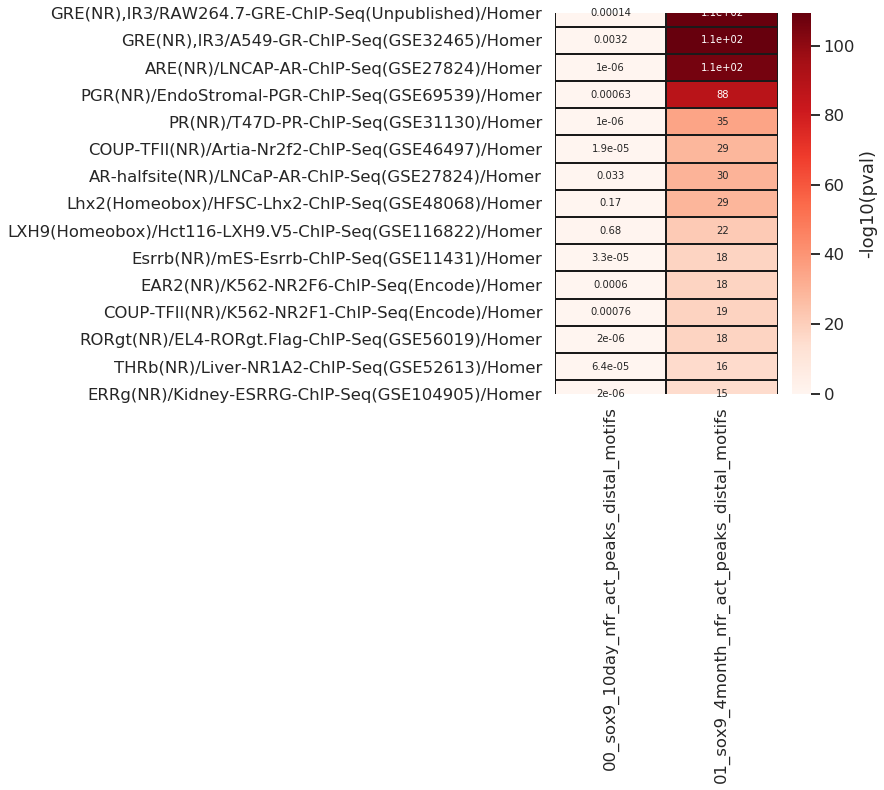

In [4]:
fig, ax = plt.subplots(figsize=(5,7))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=-6).any(axis=1),
                                known_motif_pval_frame.columns.str.contains('distal')].head(15),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)

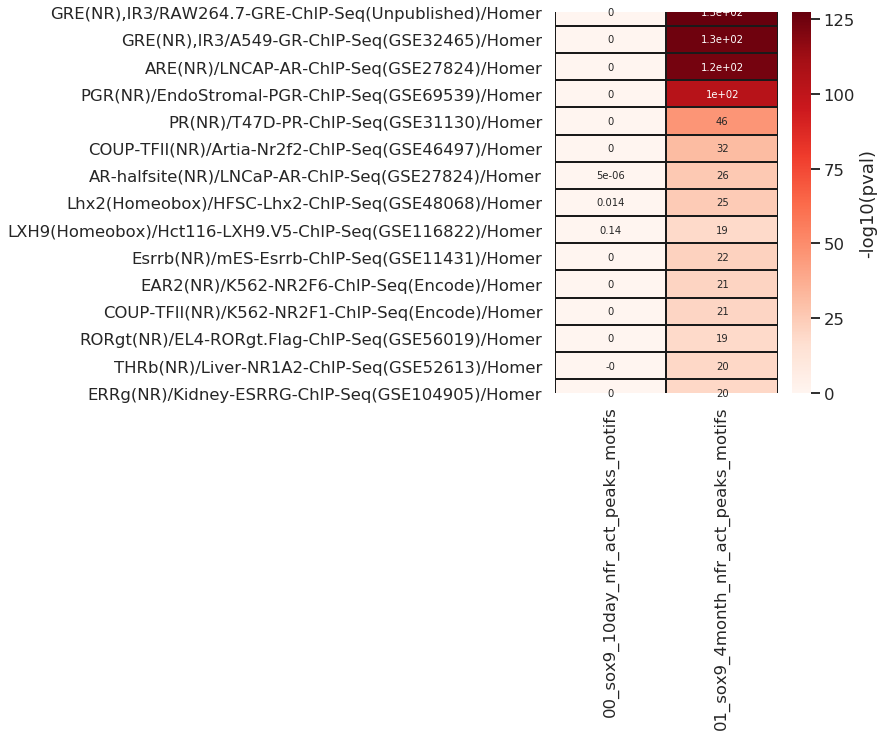

In [5]:
fig, ax = plt.subplots(figsize=(5,7))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=-6).any(axis=1),
                                ~known_motif_pval_frame.columns.str.contains('distal')].head(15),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)

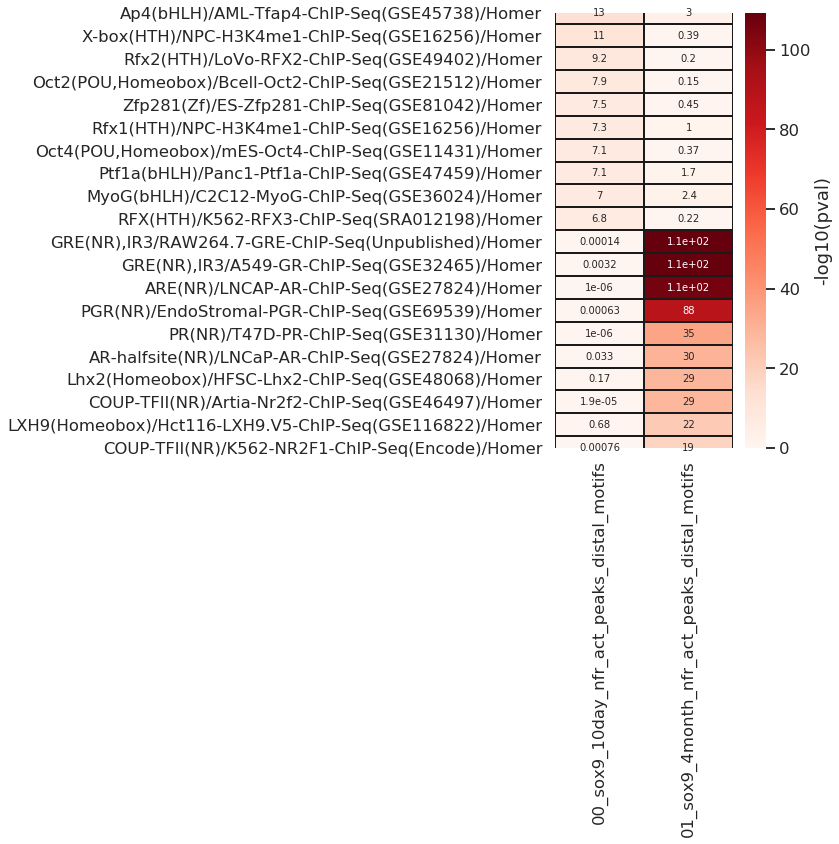

In [20]:
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('distal')]

motif_list = []
n_motifs = 10
for col in tmp_frame.columns:
    motif_list.extend(tmp_frame.sort_values(col).index.tolist()[:n_motifs])

fig, ax = plt.subplots(figsize=(4,8))

sns.heatmap(
    -tmp_frame.loc[motif_list, :],
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    vmin=0,
    ax=ax)